## Importing libraries

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
import zipfile
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Reading datasets

In [3]:
top_20_overlap_service = pd.read_csv("../datasets/filtered_final_results.csv").head(20)
top_20_overlap_service['ServiceNo'] = top_20_overlap_service['ServiceNo'].astype(str)
print(top_20_overlap_service.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             20 non-null     int64  
 1   ServiceNo              20 non-null     object 
 2   TotalStops             20 non-null     int64  
 3   WeightedParallelScore  20 non-null     float64
 4   TrainLineParallelData  20 non-null     object 
dtypes: float64(1), int64(2), object(2)
memory usage: 932.0+ bytes
None


## Feature 1: Passenger Volume

In [4]:
pv_trend = pd.read_csv("../datasets/pv_eda/routes_pv_trend.csv")
print(pv_trend.head())

  ServiceNo     2024-07     2024-08     2024-09       Trend  Trend_Binary  \
0        10  22843384.0  23052832.0  21563610.0  Increasing             1   
1       100  15513408.0  15394684.0  14991330.0  Decreasing             0   
2      100A   1458770.0   1434772.0   1390170.0  Decreasing             0   
3       101   4203807.0   4119248.0   3918423.0  Decreasing             0   
4       102   5460389.0   5304970.0   5025364.0  Decreasing             0   

      Change       Average  
0 -1279774.0  2.248661e+07  
1  -522078.0  1.529981e+07  
2   -68600.0  1.427904e+06  
3  -285384.0  4.080493e+06  
4  -435025.0  5.263574e+06  


In [5]:
top_20_pv_trend = pd.merge(top_20_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_20_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               1.792254   
1         219        48         105               1.513026   
2          12       107          79               1.419038   
3         196        36          61               1.380328   
4          38       122          39               1.323077   

                               TrainLineParallelData     2024-07     2024-08  \
0  {'BP': [{'ParallelStopCodes': ['44461', '44451...  40651926.0  40107168.0   
1  {'CC': [{'ParallelStopCodes': ['41021', '41119...   9789624.0   9783592.0   
2  {'DT': [{'ParallelStopCodes': ['60039', '60029...  11919460.0  11668796.0   
3  {'CC': [{'ParallelStopCodes': ['02149', '02171...   2731454.0   2755434.0   
4  {'EW': [{'ParallelStopCodes': ['06011', '06051...   2524376.0   2495384.0   

      2024-09       Trend  Trend_Binary     Change       Average  
0  37781528.0  Decreasing             0 -2870398.0  3.951354e+07  
1   9240800.

In [6]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_20_pv_trend['Change_Normalized'] = top_20_pv_trend['Change'] / top_20_pv_trend['TotalStops']
top_20_pv_trend['Average_Normalized'] = top_20_pv_trend['Average'] / top_20_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_20_pv_trend['Change_Normalized'].mean()
change_std = top_20_pv_trend['Change_Normalized'].std()
top_20_pv_trend['Change_Standardized'] = (top_20_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
    -np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_20_pv_trend['Average_Standardized'] = scaler.fit_transform(top_20_pv_trend[['Average_Normalized']])

top_20_pv_trend = top_20_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 'TrainLineParallelData', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_20_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  \
0         67         163               1.792254   
1         48         105               1.513026   
2        107          79               1.419038   
3         36          61               1.380328   
4        122          39               1.323077   
5        170         130               1.241430   
6          2         131               1.195465   
7         63         102               1.188235   
8         65         128               1.184811   
9        100         111               1.180604   
10        24         100               1.174000   
11        80         118               1.173851   
12       851         108               1.150687   
13       111          56               1.146429   
14       134          36               1.127778   
15       158          69               1.124638   
16        13         129               1.099351   
17       133          86               1.083658   
18       147         146       

## Count of alternative bus routes

In [7]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)

In [8]:
# Filter for Trunk Services
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
trunk_buses_df = trunk_buses_df['ServiceNo']
trunk_bus_routes_df = pd.merge(trunk_buses_df, bus_routes_df, on='ServiceNo', how='inner')

# Select relevant columns
trunk_bus_routes_df = trunk_bus_routes_df[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode']]

# Sort the trunk bus routes by Direction and StopSequence
trunk_bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'], inplace=True)

# Group by ServiceNo and create an ordered list of BusStopCodes for each service
ordered_stops = trunk_bus_routes_df.groupby('ServiceNo').agg(
    OrderedBusStops=('BusStopCode', lambda x: list(x))
).reset_index()

# Display the result
print(ordered_stops.head())

  ServiceNo                                    OrderedBusStops
0        10  [75009, 75009, 76059, 76059, 76069, 76069, 962...
1       100  [66009, 66009, 62129, 62129, 62119, 62119, 610...
2      100A  [66009, 62129, 62119, 61049, 61039, 70069, 700...
3       101  [66009, 62131, 62141, 63011, 63021, 63031, 630...
4       102  [64009, 64041, 64051, 64061, 64401, 67739, 677...


## Feature 3 : Average Distance of bus stops to train stations 

In [9]:
avg_dist_df = pd.read_pickle("../datasets/overlap_results_with_road_distance3.pkl")

In [10]:
avg_dist_df.head()

,ServiceNo,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,10,146,0.855912,0.001797,"{'75009': [[0.23621599952756797, 'EW2', 'East-...",TRUNK
1,100,109,0.838644,0.001828,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK
2,100A,13,0.870323,0.001771,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK
3,101,45,0.822894,0.001857,"{'62131': [[0.184851999630296, 'NE12', 'North ...",TRUNK
4,102,59,0.857730,0.001794,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK


In [13]:
top_20_features = pd.merge(top_20_pv_trend,avg_dist_df, on = 'ServiceNo')

In [14]:
top_20_features

,ServiceNo,TotalStops,WeightedParallelScore,TrainLineParallelData,Trend_Binary,Change_Standardized,Average_Standardized,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,67,163,1.792254,"{'BP': [{'ParallelStopCodes': ['44461', '44451...",0,-2.160795,1.000000,161,0.737742,0.002022,"{'44009': [[0.6490839987018319, 'NS4', 'North-...",TRUNK
1,48,105,1.513026,"{'CC': [{'ParallelStopCodes': ['41021', '41119...",0,-0.591609,0.262200,103,0.773233,0.001952,"{'85099': [[0.26772999946453996, 'EW4', 'East-...",TRUNK
2,107,79,1.419038,"{'DT': [{'ParallelStopCodes': ['60039', '60029...",0,-0.381085,0.531761,77,0.745774,0.002006,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK
3,36,61,1.380328,"{'CC': [{'ParallelStopCodes': ['02149', '02171...",1,1.396551,0.031979,60,0.668416,0.002167,"{'95129': [[0.0, 'CG2', 'Changi Airport Branch...",TRUNK
4,122,39,1.323077,"{'EW': [{'ParallelStopCodes': ['06011', '06051...",0,-0.831323,0.123498,38,0.805609,0.001890,"{'10017': [[0.74851999850296, 'EW16', 'East-We...",TRUNK
5,170,130,1.241430,"{'DT': [{'ParallelStopCodes': ['07531', '40011...",0,-0.425222,0.605512,126,0.772111,0.001954,"{'01109': [[0.6014639987970719, 'DT22', 'Downt...",TRUNK
6,2,131,1.195465,"{'DT': [{'ParallelStopCodes': ['96059', '04239...",0,-0.154607,0.401434,129,0.848269,0.001811,"{'96059': [[0.337453999325092, 'DT34', 'Downto...",TRUNK
7,63,102,1.188235,"{'CC': [{'ParallelStopCodes': ['70181'], 'Para...",0,-0.820605,0.128731,101,0.730902,0.002036,"{'82009': [[0.251325999497348, 'EW7', 'East-We...",TRUNK
8,65,128,1.184811,"{'CC': [{'ParallelStopCodes': ['08031', '14019...",0,-1.273096,0.788277,126,0.795562,0.001909,"{'75009': [[0.23621599952756797, 'EW2', 'East-...",TRUNK
9,100,111,1.180604,"{'CC': [{'ParallelStopCodes': ['01429', '01419...",0,-0.707967,0.488822,109,0.838644,0.001828,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK


In [16]:
top_20_features = top_20_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_20_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [18]:
# # Apply StandardScaler to standardize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

In [19]:
features_scaled

array([[1.        , 0.        , 0.30689715],
       [0.60938085, 0.44111151, 0.4640084 ],
       [0.47789923, 0.50029171, 0.3424511 ],
       [0.42374605, 1.        , 0.        ],
       [0.34365632, 0.37372589, 0.60733168],
       [0.22943835, 0.48788435, 0.45904194],
       [0.16513715, 0.56395655, 0.79618292],
       [0.1550231 , 0.37673889, 0.27661397],
       [0.15023241, 0.24953988, 0.56285638],
       [0.1443479 , 0.40840218, 0.7535729 ],
       [0.135109  , 0.55955251, 0.68711638],
       [0.13489997, 0.53353093, 0.54200159],
       [0.10249562, 0.33998095, 0.46840426],
       [0.09653866, 0.16566299, 0.15198784],
       [0.07044762, 0.39361345, 0.4006501 ],
       [0.06605486, 0.35350842, 0.09297187],
       [0.03068066, 0.20970856, 0.9601579 ],
       [0.0087274 , 0.4491157 , 0.36668792],
       [0.0021915 , 0.33682282, 0.54024654],
       [0.        , 0.52701637, 1.        ]])

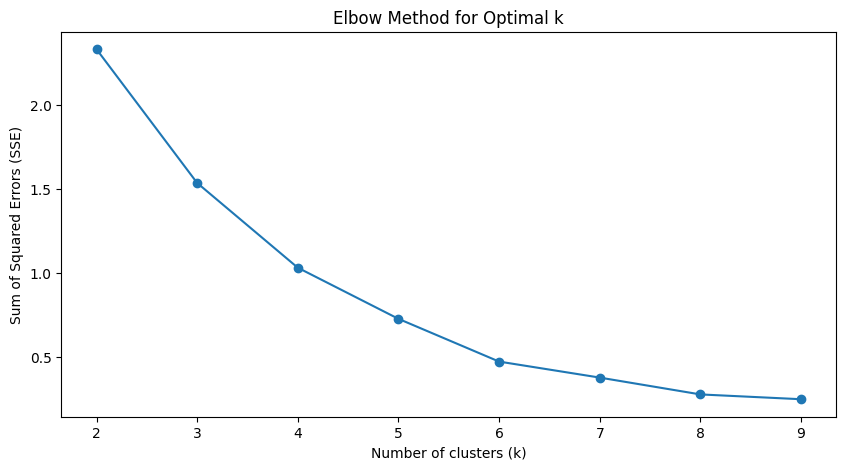

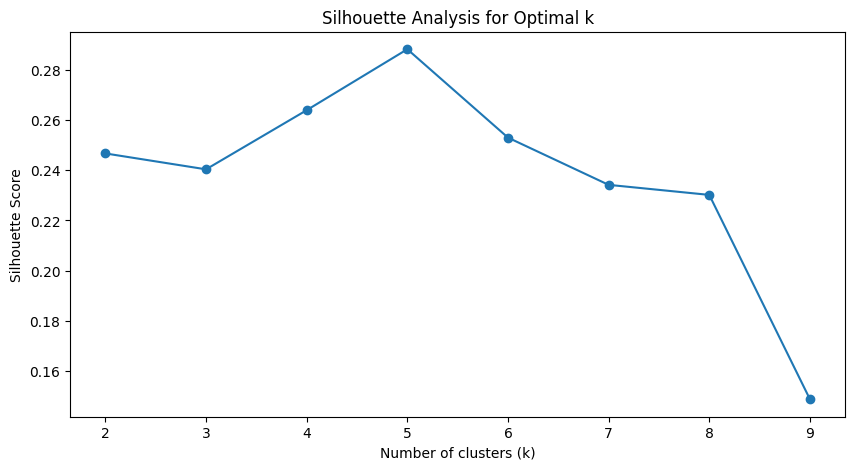

Silhouette score for k=2: 0.247
Silhouette score for k=3: 0.240
Silhouette score for k=4: 0.264
Silhouette score for k=5: 0.288
Silhouette score for k=6: 0.253
Silhouette score for k=7: 0.234
Silhouette score for k=8: 0.230
Silhouette score for k=9: 0.149


In [20]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.10410366 0.36664354 0.31662256]
 [0.12291721 0.41802841 0.71660737]
 [1.         0.         0.30689715]
 [0.42374605 1.         0.        ]
 [0.54364004 0.47070161 0.40322975]]
Top 20 features with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.000000          0.306897        2
1               0.609381     0.441112          0.464008        4
2               0.477899     0.500292          0.342451        4
3               0.423746     1.000000          0.000000        3
4               0.343656     0.373726          0.607332        1


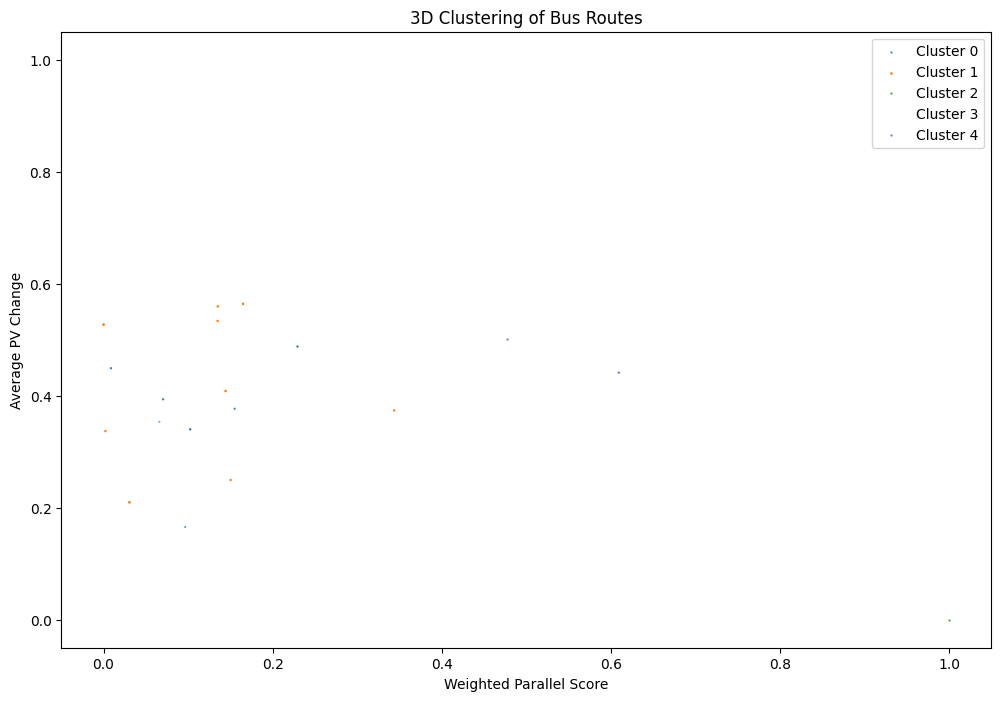

In [21]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming features array is already normalized and stored in a variable called `features`
k = 5  # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_20_features_df = pd.DataFrame(features_scaled, columns=columns)
top_20_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 20 features with cluster assignments:")
print(top_20_features_df.head())


plt.figure(figsize=(12, 8))
for i in range(k):
    cluster_data = top_20_features_df[top_20_features_df['Cluster'] == i]
    plt.scatter(cluster_data['WeightedParallelScore'], cluster_data['AvgPVChange'], cluster_data['AvgDistanceToMRT'], label=f'Cluster {i}')

plt.xlabel('Weighted Parallel Score')
plt.ylabel('Average PV Change')
plt.title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




In [23]:
print(top_20_features_df.head(n=20))

    WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0                1.000000     0.000000          0.306897        2
1                0.609381     0.441112          0.464008        4
2                0.477899     0.500292          0.342451        4
3                0.423746     1.000000          0.000000        3
4                0.343656     0.373726          0.607332        1
5                0.229438     0.487884          0.459042        0
6                0.165137     0.563957          0.796183        1
7                0.155023     0.376739          0.276614        0
8                0.150232     0.249540          0.562856        1
9                0.144348     0.408402          0.753573        1
10               0.135109     0.559553          0.687116        1
11               0.134900     0.533531          0.542002        1
12               0.102496     0.339981          0.468404        0
13               0.096539     0.165663          0.151988        0
14        

In [24]:
top_20_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT
0,67,1.792254,-2.160795,0.737742
1,48,1.513026,-0.591609,0.773233
2,107,1.419038,-0.381085,0.745774
3,36,1.380328,1.396551,0.668416
4,122,1.323077,-0.831323,0.805609
5,170,1.241430,-0.425222,0.772111
6,2,1.195465,-0.154607,0.848269
7,63,1.188235,-0.820605,0.730902
8,65,1.184811,-1.273096,0.795562
9,100,1.180604,-0.707967,0.838644


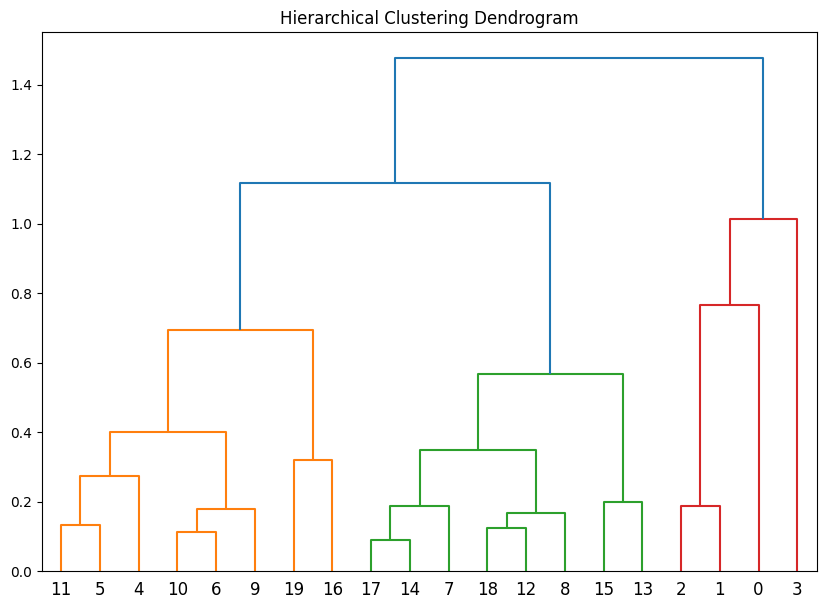

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Cluster
0         67               1.792254 -2.160795          0.737742        2
1         48               1.513026 -0.591609          0.773233        1
2        107               1.419038 -0.381085          0.745774        1
3         36               1.380328  1.396551          0.668416        3
4        122               1.323077 -0.831323          0.805609        5
5        170               1.241430 -0.425222          0.772111        5
6          2               1.195465 -0.154607          0.848269        5
7         63               1.188235 -0.820605          0.730902        4
8         65               1.184811 -1.273096          0.795562        4
9        100               1.180604 -0.707967          0.838644        5
10        24               1.174000 -0.170273          0.823632        5
11        80               1.173851 -0.262841          0.790851        5
12       851               1.1

C:\Users\Gene\AppData\Local\Temp\ipykernel_19256\3331086595.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_features['Cluster'] = cluster_labels


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in `top_20_features` DataFrame
# and contains 'WeightedParallelScore', 'AvgPVChange', and 'AvgDistanceToMRT' columns

# Step 1: Normalize the data using MinMaxScaler (or StandardScaler if preferred)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

# Step 2: Perform hierarchical clustering
linked = linkage(features_scaled, method='ward')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Step 4: Cut the dendrogram to form clusters
# Choose a threshold or number of clusters, e.g., 5 clusters
num_clusters = 5
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_20_features['Cluster'] = cluster_labels

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_20_features)

# Save results if needed
top_20_features.to_csv('hierarchical_clustered_bus_routes.csv', index=False)
